# Best case

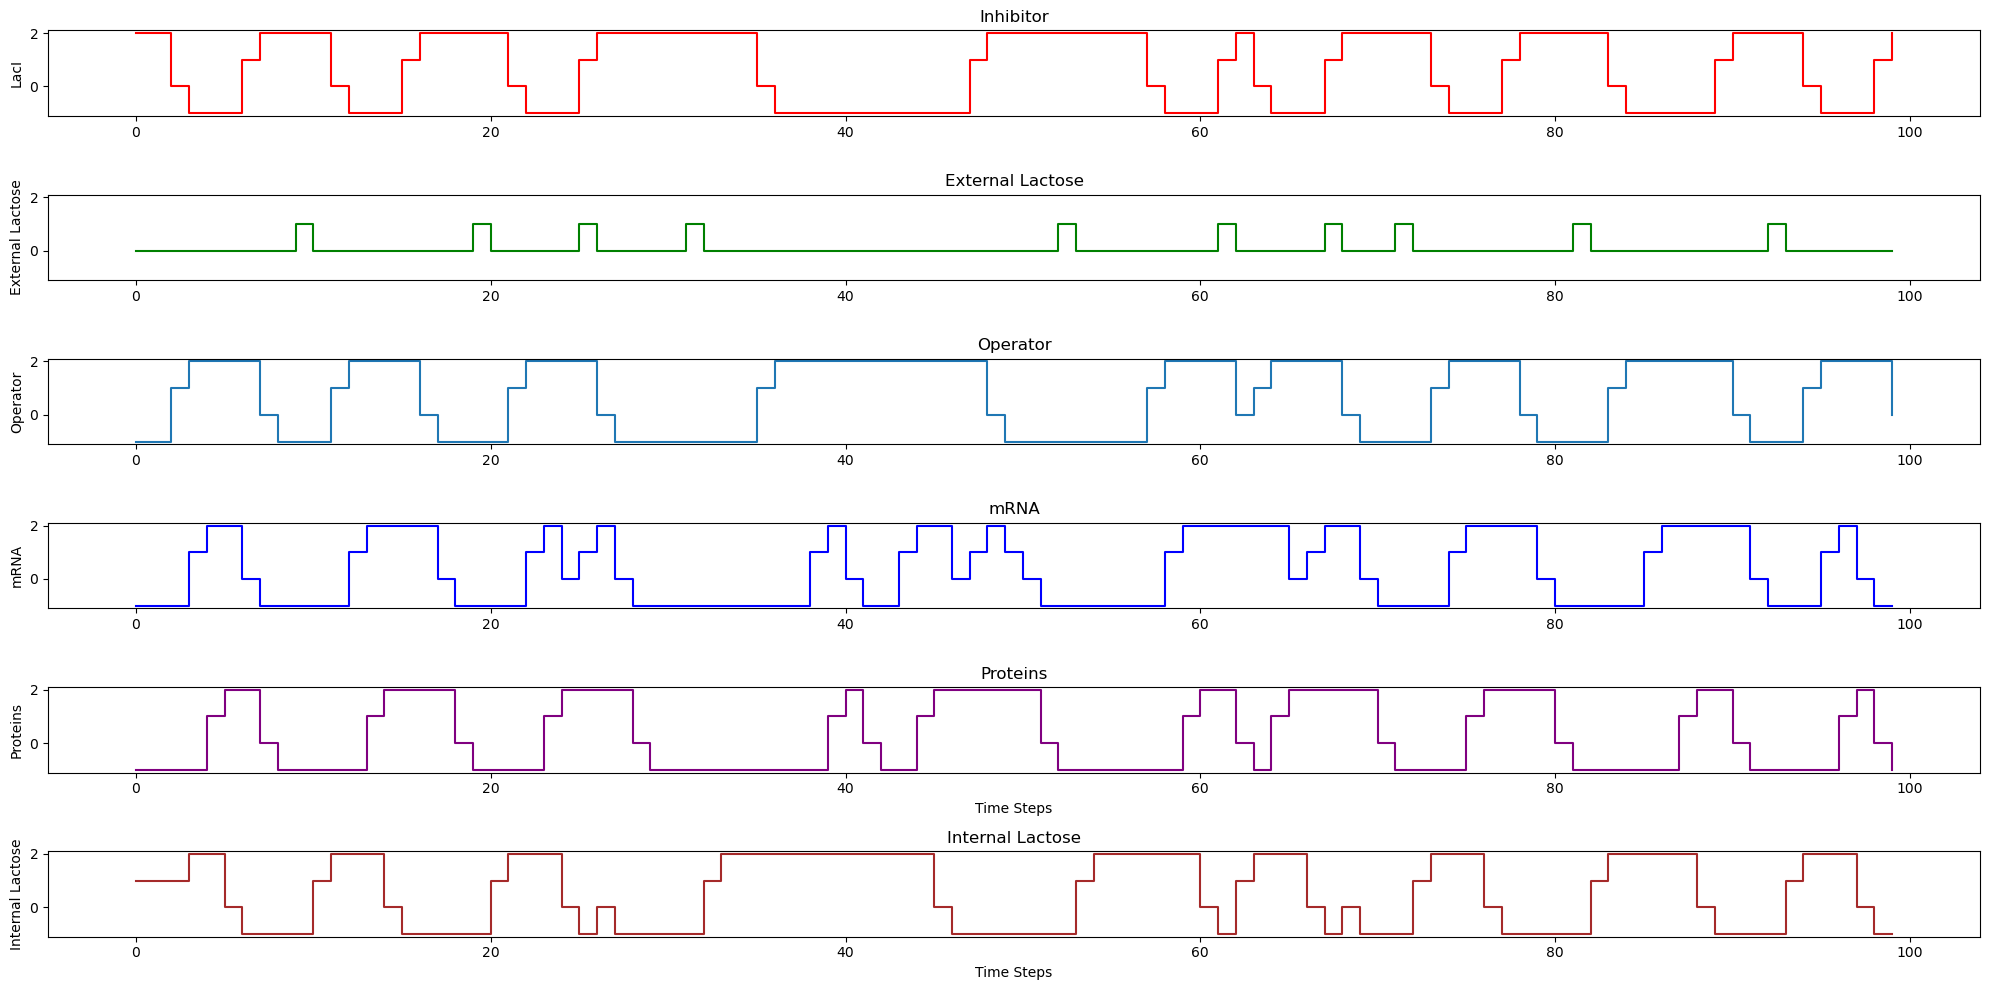

In [3]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0

def simulate_system(params, steps=100):
    states = {'O': 0, 'I': 1, 'L': 1, 'Li': 0, 'M': 0, 'P': 0}
    history = np.zeros((steps, 6))
    for t in range(steps):
        if t>1:
            if states['Li']==1:
                states['Li']=2
            if states['Li']==0:
                states['Li']=(-1)

        # if we have external lactose
        if states['L'] == 1:
            # internal lactose is on
            states['Li']=1
            # external lactose is off 
            states['L']=0

        # if lactose is on
        if states['I']==0:
            states['I']=-1
        if states['I']==1:
            states['I']=2
        if states['Li'] == 2 and t>1 and states['I']>0:
            # if lactose has been on for the last 2 epochs

                # update the status of Inhibitor based on probability of binding of lactose to inhibitor
            temp_state = update_state(states['I'], 1-params['lactose_binding'])
            if temp_state==1:
                states['I']=states['I']
            else:
                states['I']=0
        # if lactose is off  
        elif states['Li']==(-1) and t>1 and states['I']<1:
            #if inhibitor is off

                # update inhibitor status based on ability of inhibitor to operon
            temp_state = update_state(states['I'], params['lacI_binding'])
            if temp_state==0:
                states['I']=states['I']
            else:
                states['I']=1
            

        if states['O']==0:
            states['O']=(-1)
        elif states['O']==1:
            states['O']=2

        if states['I'] == 0 and t>1 and states['O']!=2:

            states['O']=1
        elif states['I']==2 and t>1 and states['O']>0:
            states['O']=0




        if states['M']==0:
            states['M']=(-1)
        if states['M']==1:
            states['M']=2
        if states['O']==2 and t>2:
            # if operon has been on for the last 2 epochs and mRNA is off
            if states['M']<=0:
                # update mRNA 
                temp_state = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
                if temp_state==0:
                    states['M']=states['M']
                else:
                    states['M']=1
            # if operon has been on for the last 2 epochs and mRNA is on
            elif states['M']>=1:
                # update mRNA, with a probability of degradation
                temp_state1 = update_state(states['M'], params['mRNA_production_withinitialoperator'])
                #temp_state2=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
                if temp_state1==1:
                    states['M']=2
                else:
                    states['M']=0

            # enough epochs has not passed for operon state change to have an impact 
        elif states['O']==1:
            states['M']=states['M']
        elif states['O']==0:
            states['M']=states['M']
        # if operon is off    
        elif states['O']==(-1):
            # if operon has been of for more than 2 epochs, and mRNA is still on
            if states['M']>=1:
                # update status of mRNA, with high degradation
                states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
        elif t<=2:
            states['M']=0


        if states['P']==0:
            states['P']=(-1)
        if states['P']==1:
            states['P']=2
        # if mRNA is on
        if states['M']==2 and t>2:
            # if mRNA has been on for the last 2 epochs and protein is off
            if states['P']<=0:
                # update protein
                temp_state = update_state(states['P'], params['protein_production_withoutinitialprotein'])
                if temp_state==0:
                    states['P']=states['P']
                else:
                    states['P']=1
             # if mRNA has been on for the last 2 epochs and protein is on
            elif states['P']>=1:
                # update protein, with a probability of degradation
                temp_state1 = update_state(states['P'], params['protein_production_withinitialprotein'])
                #temp_state2=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
                if temp_state1==1:
                    states['P']=2
                else:
                    states['P']=0
            # enough epochs has not passed for mRNA state change to have an impact 
        elif states['M']==1:
            states['P']=states['P']
        elif states['M']==0:
            states['P']=states['P']
        # if mRNA is off      
        elif states['M']==(-1):
            # if mRNA has been of for more than 2 epochs, and protein is still on
            if states['P']>=1:
                # update status of protein, with high degradation
                states['P']=update_state(states['P'],params['protein_degradation_withoutmRNA'])
        elif t<=2:
            states['P']=0


        # if protein is on
        #print(t,states['Li'])
        if states['P']==2 and t>2:
            # if protein has been of for more than 2 epochs, and lactose is still on
            if states['Li']>=1:
                # switch off lactose
                temp_state=update_state(states['Li'], 1-params['lactose_internalization'])
                if temp_state==1:
                    states['Li']=states['Li']
                else:
                    states['Li']=0
            else:
                if states['Li']<=0:
                    states['Li']=states['Li']
        elif t<=2:
            states['Li']=1

        #print(t,states['Li'])   

        history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
        # if lactose is off
        if states['Li'] == (-1):
            # if lactose has been off for the last 3 epochs

                # try to bring in external lactose
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        
        
    return history
params = {
    'lacI_binding': 0.8,   # Probability LacI binds to Operon if free
    'lactose_binding': 0.8, # Probability lactose binds to LacI
    'lactose_internalization': 0.8,  # degradation of lactose by protein
   
    'mRNA_production_withoutinitialoperator': 0.8, # production of mRNA by operon if it has just become free
    'mRNA_production_withinitialoperator': 0.9, # production of mRNA by operon if it has been free for some time
    'mRNA_degradation_withoperator': 0.9, # mRNA stability if operon is free
    'mRNA_degradation_withoutoperator': 0.1, #mRNA stability is operon is off
    'protein_production_withoutinitialprotein': 0.8,  # production of protein by mRNA if it has just been transcribed 
    'protein_production_withinitialprotein': 0.9,  # production of protein by operon if it has been transcribed for some time
    'protein_degradation_withmRNA': 0.1, # protein stability if mRNA is being produced
    'protein_degradation_withoutmRNA': 0.1,  # protein stability is mRNA is not being produced
    'entry of lactose': 0.3 #entering of external lactose into the cell 

}
history=simulate_system(params,100)
from matplotlib import pyplot as plt
steps=len(history)
plt.figure(figsize=(20,10))


plt.subplot(6, 1, 1)
plt.step(range(steps), history[:,1], label='LacI', color='r', where='post')
plt.ylabel('LacI')

plt.title('Inhibitor')
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 2)
plt.step(range(steps), history[:,2], label='Lactose', color='g', where='post')
plt.ylabel('External Lactose')
plt.title('External Lactose')
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 3)
plt.step(range(steps), history[:,0], label='Operator', where='post')
plt.ylabel('Operator')
plt.title('Operator')
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 4)
plt.step(range(steps), history[:,4], label='mRNA', color='b', where='post')
plt.ylabel('mRNA')
plt.title('mRNA')
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 5)
plt.step(range(steps), history[:,5], label='Proteins', color='purple', where='post')
plt.ylabel('Proteins')
plt.title('Proteins')
plt.ylim(-1.1, 2.1)
plt.xlabel('Time Steps')

plt.subplot(6, 1, 6)
plt.step(range(steps), history[:,3], label='Li', color='brown', where='post')
plt.ylabel('Internal Lactose')
plt.title('Internal Lactose')
plt.ylim(-1.1, 2.1)
plt.xlabel('Time Steps')

plt.tight_layout()
plt.show()


# Code

# Improvment: Loss Function for non -biological agrreing states

In [3]:
def custom_loss_function(history):
    loss = 0

    # Variables to keep track of the start of prolonged states
    last_high_end_lac = 0
    last_low_end_lac = 0
    last_high_end_op = 0
    last_low_end_op = 0
    last_high_end_mrna = 0
    last_low_end_mrna = 0
    last_high_end_pro = 0
    last_low_end_pro = 0
    trans_mrna=0
    trans_pro=0
    stuck_pro=0
    stuck_mrna=0
    # Threshold for prolonged states
    threshold = 4
    threshold_inhib=8
    threshold_trans=2
    threshold_stuck=6

    for t in range(2, len(history)):
        #if history[t][1]==2 and history[t-1][1]==2 and history[t][0]>=1:
            #loss+=1
        
        '''if history[t][0] == 2 and history[t][4] < 0:
            loss += 1
        if history[t][4] == 2 and history[t][5] < 0:
            loss += 1
        if history[t][3] > 0 and history[t][2] == 1:
            loss += 1'''
        
        if history[t][0] == 2:
            if last_high_end_op==0:
                last_high_end_op=t
                   
            elif t > last_high_end_op + threshold:  # Start of a new high period
       
                loss += 1 
                #print('lac',last_high_end_lac,t)
        
        elif history[t][0] == -1:
            if last_low_end_op==0:
                last_low_end_op=t # Start of a new low period
            
            elif t > last_low_end_op + threshold:  
                loss += 1  # Penalize the start of a prolonged low period
                #print('lac',last_low_end_lac,t)

        # Reset on normal levels
        if history[t][0] not in [2, -1]:
            last_high_end_op = 0
            last_low_end_op = 0
            
            
        if history[t][1]==2:
            if history[t][3]==2:
                loss+=10
        if history[t][5]==2:
            if history[t][3]==2:
                loss+=10
        if history[t][4]==(-1):
            if history[t][5]==2:
                loss+=20
                
        # Transient penalty
        
        if history[t][4] in [0,1]:
            if trans_mrna==0:
                
                trans_mrna=t
            elif t> trans_mrna + threshold_trans:
                loss+=5
        if history[t][4] in [-1,2]:
            trans_mrna=0
        
        if history[t][5] in [0,1]:
            if trans_pro==0:
                
                trans_pro=t
            elif t> trans_pro + threshold_trans:
                loss+=5
        if history[t][5] in [-1,2]:
            trans_pro=0
        
        # penalty for getting stuck in an upper state:
        if history[t][5] in [1,2]:
            if stuck_pro==0:
                
                stuck_pro=t
            elif t> stuck_pro + threshold_stuck:
                loss+=20
        if history[t][5] in [-1,0]:
            stuck_pro=0
            
        if history[t][4] in [1,2]:
            if stuck_mrna==0:
                
                stuck_mrna=t
            elif t> stuck_mrna + threshold_stuck:
                loss+=20
        if history[t][4] in [-1,0]:
            stuck_mrna=0
        
        
        
            
        # 'Internal Lactose'
        if history[t][3] == 2:
            if last_high_end_lac==0:
                last_high_end_lac=t
                   
            elif t > last_high_end_lac + threshold:  # Start of a new high period
       
                loss += 1 
                #print('lac',last_high_end_lac,t)

        elif history[t][3] == -1:
            if last_low_end_lac==0:
                last_low_end_lac=t # Start of a new low period
            
            elif t > last_low_end_lac + threshold:  
                loss += 1  # Penalize the start of a prolonged low period
                #print('lac',last_low_end_lac,t)

        # Reset on normal levels
        if history[t][3] not in [2, -1]:
            last_high_end_lac = 0
            last_low_end_lac = 0
            
         # mRNA 
        if history[t][4] == 2:
            if last_high_end_mrna==0:
                last_high_end_mrna=t
                   
            elif t > last_high_end_mrna + threshold:  # Start of a new high period
       
                loss += 1 
                #print('mrna',last_high_end_mrna,t)

        elif history[t][4] == -1:
            if last_low_end_mrna==0:
                last_low_end_mrna=t # Start of a new low period
            
            elif t > last_low_end_mrna + threshold:  
                loss += 1  # Penalize the start of a prolonged low period
                #print('mrna',last_low_end_mrna,t)

        # Reset on normal levels
        if history[t][4] not in [2, -1]:
            last_high_end_mrna = 0
            last_low_end_mrna = 0
        
        
        # Protein
        if history[t][5] == 2:
            if last_high_end_pro==0:
                last_high_end_pro=t
                   
            elif t > last_high_end_pro + threshold:  # Start of a new high period
       
                loss += 1 
                #print('pro',last_high_end_pro,t)

        elif history[t][5] == -1:
            if last_low_end_pro==0:
                last_low_end_pro=t # Start of a new low period
            
            elif t > last_low_end_pro + threshold:  
                loss += 1  # Penalize the start of a prolonged low period
                #print('pro',last_low_end_pro,t)

        # Reset on normal levels
        if history[t][5] not in [2, -1]:
            last_high_end_pro = 0
            last_low_end_pro = 0


    return loss


In [4]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0

def simulate_system(params, steps=100):
    states = {'O': 0, 'I': 1, 'L': 1, 'Li': 0, 'M': 0, 'P': 0}
    history = np.zeros((steps, 6))
    for t in range(steps):
        if t>1:
            if states['Li']==1:
                states['Li']=2
            if states['Li']==0:
                states['Li']=(-1)

        # if we have external lactose
        if states['L'] == 1:
            # internal lactose is on
            states['Li']=1
            # external lactose is off 
            states['L']=0

        # if lactose is on
        if states['I']==0:
            states['I']=-1
        if states['I']==1:
            states['I']=2
        if states['Li'] == 2 and t>1 and states['I']>0:
            # if lactose has been on for the last 2 epochs

                # update the status of Inhibitor based on probability of binding of lactose to inhibitor
            temp_state = update_state(states['I'], 1-params['lactose_binding'])
            if temp_state==1:
                states['I']=states['I']
            else:
                states['I']=0
        # if lactose is off  
        elif states['Li']==(-1) and t>1 and states['I']<1:
            #if inhibitor is off

                # update inhibitor status based on ability of inhibitor to operon
            temp_state = update_state(states['I'], params['lacI_binding'])
            if temp_state==0:
                states['I']=states['I']
            else:
                states['I']=1
            

        if states['O']==0:
            states['O']=(-1)
        elif states['O']==1:
            states['O']=2

        if states['I'] == 0 and t>1 and states['O']!=2:

            states['O']=1
        elif states['I']==2 and t>1 and states['O']>0:
            states['O']=0




        if states['M']==0:
            states['M']=(-1)
        if states['M']==1:
            states['M']=2
        if states['O']==2 and t>2:
            # if operon has been on for the last 2 epochs and mRNA is off
            if states['M']<=0:
                # update mRNA 
                temp_state = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
                if temp_state==0:
                    states['M']=states['M']
                else:
                    states['M']=1
            # if operon has been on for the last 2 epochs and mRNA is on
            elif states['M']>=1:
                # update mRNA, with a probability of degradation
                temp_state1 = update_state(states['M'], params['mRNA_production_withinitialoperator'])
                #temp_state2=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
                if temp_state1==1:
                    states['M']=2
                else:
                    states['M']=0

            # enough epochs has not passed for operon state change to have an impact 
        elif states['O']==1:
            states['M']=states['M']
        elif states['O']==0:
            states['M']=states['M']
        # if operon is off    
        elif states['O']==(-1):
            # if operon has been of for more than 2 epochs, and mRNA is still on
            if states['M']>=1:
                # update status of mRNA, with high degradation
                states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
        elif t<=2:
            states['M']=0


        if states['P']==0:
            states['P']=(-1)
        if states['P']==1:
            states['P']=2
        # if mRNA is on
        if states['M']==2 and t>2:
            # if mRNA has been on for the last 2 epochs and protein is off
            if states['P']<=0:
                # update protein
                temp_state = update_state(states['P'], params['protein_production_withoutinitialprotein'])
                if temp_state==0:
                    states['P']=states['P']
                else:
                    states['P']=1
             # if mRNA has been on for the last 2 epochs and protein is on
            elif states['P']>=1:
                # update protein, with a probability of degradation
                temp_state1 = update_state(states['P'], params['protein_production_withinitialprotein'])
                #temp_state2=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
                if temp_state1==1:
                    states['P']=2
                else:
                    states['P']=0
            # enough epochs has not passed for mRNA state change to have an impact 
        elif states['M']==1:
            states['P']=states['P']
        elif states['M']==0:
            states['P']=states['P']
        # if mRNA is off      
        elif states['M']==(-1):
            # if mRNA has been of for more than 2 epochs, and protein is still on
            if states['P']>=1:
                # update status of protein, with high degradation
                states['P']=update_state(states['P'],1-params['protein_degradation_withoutmRNA'])
        elif t<=2:
            states['P']=0


        # if protein is on
        #print(t,states['Li'])
        if states['P']==2 and t>2:
            # if protein has been of for more than 2 epochs, and lactose is still on
            if states['Li']>=1:
                # switch off lactose
                temp_state=update_state(states['Li'], 1-params['lactose_internalization'])
                if temp_state==1:
                    states['Li']=states['Li']
                else:
                    states['Li']=0
            else:
                if states['Li']<=0:
                    states['Li']=states['Li']
        elif t<=2:
            states['Li']=1

        #print(t,states['Li'])   

        history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
        # if lactose is off
        if states['Li'] == (-1):
            # if lactose has been off for the last 3 epochs

                # try to bring in external lactose
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        
        
    return history


In [5]:
import numpy as np
import random
bu_li=[]


def search_params(temp_params, adjustment=2):
    keys = list(temp_params.keys())
    #print(keys)
    temp_best_params = temp_params.copy()
    temp_best_loss = 100000
    
  
    for combination in itertools.product([-adjustment, adjustment], repeat=len(temp_params)):
        
       
        test_params = {key: np.clip(temp_params[key] + value, 0.1, 0.9) for key, value in zip(keys, combination)}
        current_history = simulate_system(test_params)
        current_loss = custom_loss_function(current_history)
        
        if current_loss < temp_best_loss:
            temp_best_loss = current_loss
            temp_best_params = test_params

    return temp_best_params, temp_best_loss
# try to simulate simulated annealing
def simulated_annealing(initial_params, simulate_system, custom_loss_function, iterations=100, temp_initial=100.0, cooling_rate=0.95, perturbation_scale=0.1):
    current_params = initial_params.copy()
    current_history = simulate_system(current_params)
    current_loss = custom_loss_function(current_history)
    best_params = current_params.copy()
    best_loss = current_loss
    temp = temp_initial

    for i in range(iterations):
        
        candidate_params = {}
        
        perturbation = np.random.normal(0.1,0.05*perturbation_scale*temp)
            

        candidate_params,candidate_loss = search_params(current_params,perturbation)
        
        print(i,candidate_loss)
        # We calculate the acceptance probability
        if candidate_loss < current_loss:
            acceptance_prob = 1.0
        else:
            acceptance_prob = np.exp((current_loss - candidate_loss) / temp)

        # Now, we decide whether to accept the candidate
        if random.random() < acceptance_prob:
            current_params, current_loss = candidate_params, candidate_loss
            if candidate_loss < best_loss:
                best_params, best_loss = candidate_params, candidate_loss
        bu_li.append(current_loss)
        # Cool down
        temp *= cooling_rate
       
        print(f"Iteration {i}: Current Loss = {current_loss}, Temperature = {temp}")

    return best_params, best_loss



# Example usage
initial_params = {
    'lacI_binding': 0.2,
    'lactose_binding': 0.2,
    'lactose_internalization': 0.8,
    'mRNA_production_withoutinitialoperator': 0.8,
    'mRNA_production_withinitialoperator': 0.9,
    'protein_production_withoutinitialprotein': 0.1,
    'protein_production_withinitialprotein': 0.1,
 
    'mRNA_degradation_withoutoperator': 0.1,

    'protein_degradation_withoutmRNA': 0.1,
    'entry of lactose': 0.3
}
optimized_params, optimized_loss = simulated_annealing(initial_params, simulate_system, custom_loss_function)
print("Optimized Parameters:", optimized_params)
print("Optimized Loss:", optimized_loss)


0 209
Iteration 0: Current Loss = 209, Temperature = 198.0
1 296
Iteration 1: Current Loss = 296, Temperature = 196.02
2 336
Iteration 2: Current Loss = 336, Temperature = 194.0598
3 243
Iteration 3: Current Loss = 243, Temperature = 192.119202
4 288
Iteration 4: Current Loss = 288, Temperature = 190.19800998
5 658
Iteration 5: Current Loss = 658, Temperature = 188.2960298802
6 272
Iteration 6: Current Loss = 272, Temperature = 186.413069581398
7 224
Iteration 7: Current Loss = 224, Temperature = 184.54893888558402
8 319
Iteration 8: Current Loss = 319, Temperature = 182.70344949672818
9 331
Iteration 9: Current Loss = 331, Temperature = 180.8764150017609
10 417
Iteration 10: Current Loss = 331, Temperature = 179.06765085174328
11 319
Iteration 11: Current Loss = 319, Temperature = 177.27697434322585
12 330
Iteration 12: Current Loss = 330, Temperature = 175.50420459979358
13 344
Iteration 13: Current Loss = 344, Temperature = 173.74916255379566
14 317
Iteration 14: Current Loss = 317,

# Visualize the final function

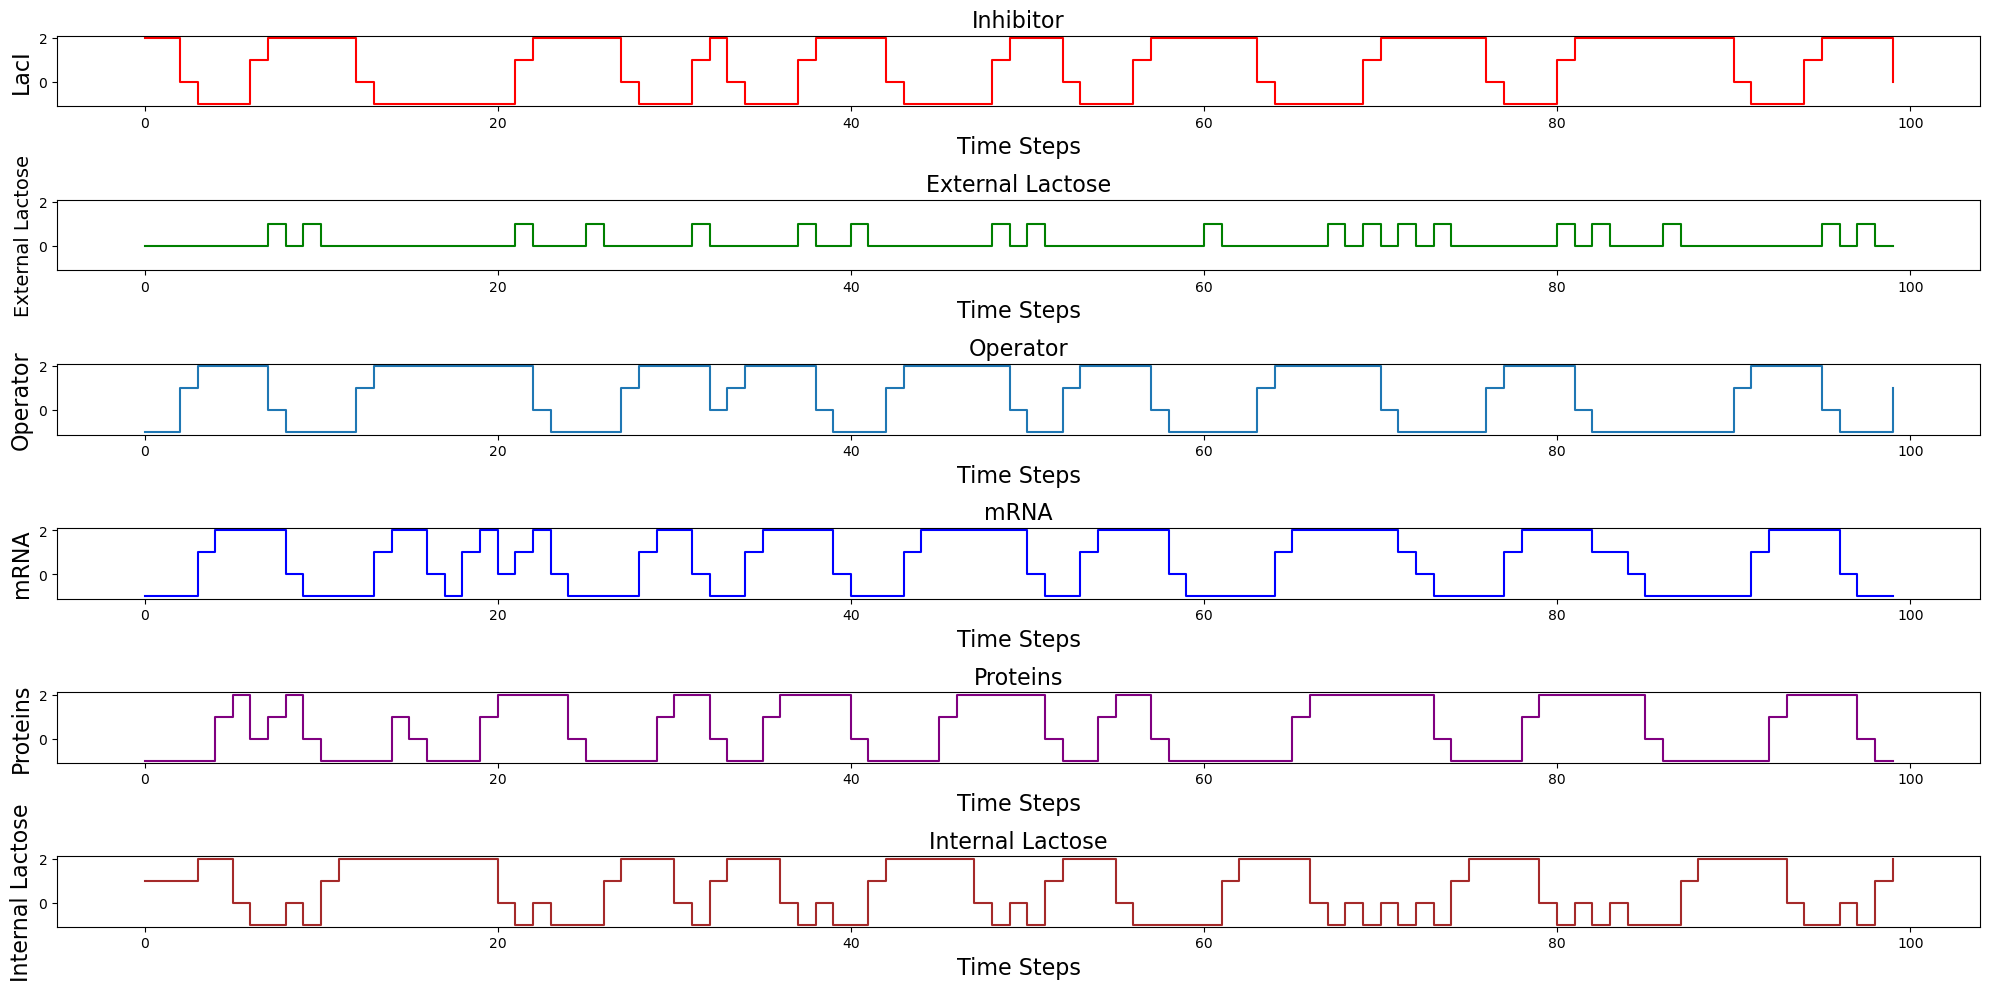

In [102]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0

def simulate_system(params, steps=100):
    states = {'O': 0, 'I': 1, 'L': 1, 'Li': 0, 'M': 0, 'P': 0}
    history = np.zeros((steps, 6))
    for t in range(steps):
        if t>1:
            if states['Li']==1:
                states['Li']=2
            if states['Li']==0:
                states['Li']=(-1)

        # if we have external lactose
        if states['L'] == 1:
            # internal lactose is on
            states['Li']=1
            # external lactose is off 
            states['L']=0

        # if lactose is on
        if states['I']==0:
            states['I']=-1
        if states['I']==1:
            states['I']=2
        if states['Li'] == 2 and t>1 and states['I']>0:
            # if lactose has been on for the last 2 epochs

                # update the status of Inhibitor based on probability of binding of lactose to inhibitor
            temp_state = update_state(states['I'], 1-params['lactose_binding'])
            if temp_state==1:
                states['I']=states['I']
            else:
                states['I']=0
        # if lactose is off  
        elif states['Li']==(-1) and t>1 and states['I']<1:
            #if inhibitor is off

                # update inhibitor status based on ability of inhibitor to operon
            temp_state = update_state(states['I'], params['lacI_binding'])
            if temp_state==0:
                states['I']=states['I']
            else:
                states['I']=1
            

        if states['O']==0:
            states['O']=(-1)
        elif states['O']==1:
            states['O']=2

        if states['I'] == 0 and t>1 and states['O']!=2:

            states['O']=1
        elif states['I']==2 and t>1 and states['O']>0:
            states['O']=0




        if states['M']==0:
            states['M']=(-1)
        if states['M']==1:
            states['M']=2
        if states['O']==2 and t>2:
            # if operon has been on for the last 2 epochs and mRNA is off
            if states['M']<=0:
                # update mRNA 
                temp_state = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
                if temp_state==0:
                    states['M']=states['M']
                else:
                    states['M']=1
            # if operon has been on for the last 2 epochs and mRNA is on
            elif states['M']>=1:
                # update mRNA, with a probability of degradation
                temp_state1 = update_state(states['M'], params['mRNA_production_withinitialoperator'])
                #temp_state2=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
                if temp_state1==1:
                    states['M']=2
                else:
                    states['M']=0

            # enough epochs has not passed for operon state change to have an impact 
        elif states['O']==1:
            states['M']=states['M']
        elif states['O']==0:
            states['M']=states['M']
        # if operon is off    
        elif states['O']==(-1):
            # if operon has been of for more than 2 epochs, and mRNA is still on
            if states['M']>=1:
                # update status of mRNA, with high degradation
                states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
        elif t<=2:
            states['M']=0


        if states['P']==0:
            states['P']=(-1)
        if states['P']==1:
            states['P']=2
        # if mRNA is on
        if states['M']==2 and t>2:
            # if mRNA has been on for the last 2 epochs and protein is off
            if states['P']<=0:
                # update protein
                temp_state = update_state(states['P'], params['protein_production_withoutinitialprotein'])
                if temp_state==0:
                    states['P']=states['P']
                else:
                    states['P']=1
             # if mRNA has been on for the last 2 epochs and protein is on
            elif states['P']>=1:
                # update protein, with a probability of degradation
                temp_state1 = update_state(states['P'], params['protein_production_withinitialprotein'])
                #temp_state2=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
                if temp_state1==1:
                    states['P']=2
                else:
                    states['P']=0
            # enough epochs has not passed for mRNA state change to have an impact 
        elif states['M']==1:
            states['P']=states['P']
        elif states['M']==0:
            states['P']=states['P']
        # if mRNA is off      
        elif states['M']==(-1):
            # if mRNA has been of for more than 2 epochs, and protein is still on
            if states['P']>=1:
                # update status of protein, with high degradation
                states['P']=update_state(states['P'],1-params['protein_degradation_withoutmRNA'])
        elif t<=2:
            states['P']=0


        # if protein is on
        #print(t,states['Li'])
        if states['P']==2 and t>2:
            # if protein has been of for more than 2 epochs, and lactose is still on
            if states['Li']>=1:
                # switch off lactose
                temp_state=update_state(states['Li'], 1-params['lactose_internalization'])
                if temp_state==1:
                    states['Li']=states['Li']
                else:
                    states['Li']=0
            else:
                if states['Li']<=0:
                    states['Li']=states['Li']
        elif t<=2:
            states['Li']=1

        #print(t,states['Li'])   

        history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
        # if lactose is off
        if states['Li'] == (-1):
            # if lactose has been off for the last 3 epochs

                # try to bring in external lactose
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        
        
    return history
history=simulate_system(optimized_params,100)
from matplotlib import pyplot as plt
steps=len(history)
plt.figure(figsize=(20,10))


plt.subplot(6, 1, 1)
plt.step(range(steps), history[:,1], label='LacI', color='r', where='post')
plt.ylabel('LacI',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.title('Inhibitor',fontsize=16)
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 2)
plt.step(range(steps), history[:,2], label='Lactose', color='g', where='post')
plt.ylabel('External Lactose',fontsize=14)
plt.title('External Lactose',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 3)
plt.step(range(steps), history[:,0], label='Operator', where='post')
plt.ylabel('Operator',fontsize=16)
plt.title('Operator',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 4)
plt.step(range(steps), history[:,4], label='mRNA', color='b', where='post')
plt.ylabel('mRNA',fontsize=16)
plt.title('mRNA',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 5)
plt.step(range(steps), history[:,5], label='Proteins', color='purple', where='post')
plt.ylabel('Proteins',fontsize=16)
plt.title('Proteins',fontsize=16)
plt.ylim(-1.1, 2.1)
plt.xlabel('Time Steps',fontsize=16)

plt.subplot(6, 1, 6)
plt.step(range(steps), history[:,3], label='Li', color='brown', where='post')
plt.ylabel('Internal Lactose',fontsize=16)
plt.title('Internal Lactose',fontsize=16)
plt.ylim(-1.1, 2.1)
plt.xlabel('Time Steps',fontsize=16)
#plt.savefig("Final_image_after_optimization.png")
plt.tight_layout()
plt.show()



# Visualize the initial function

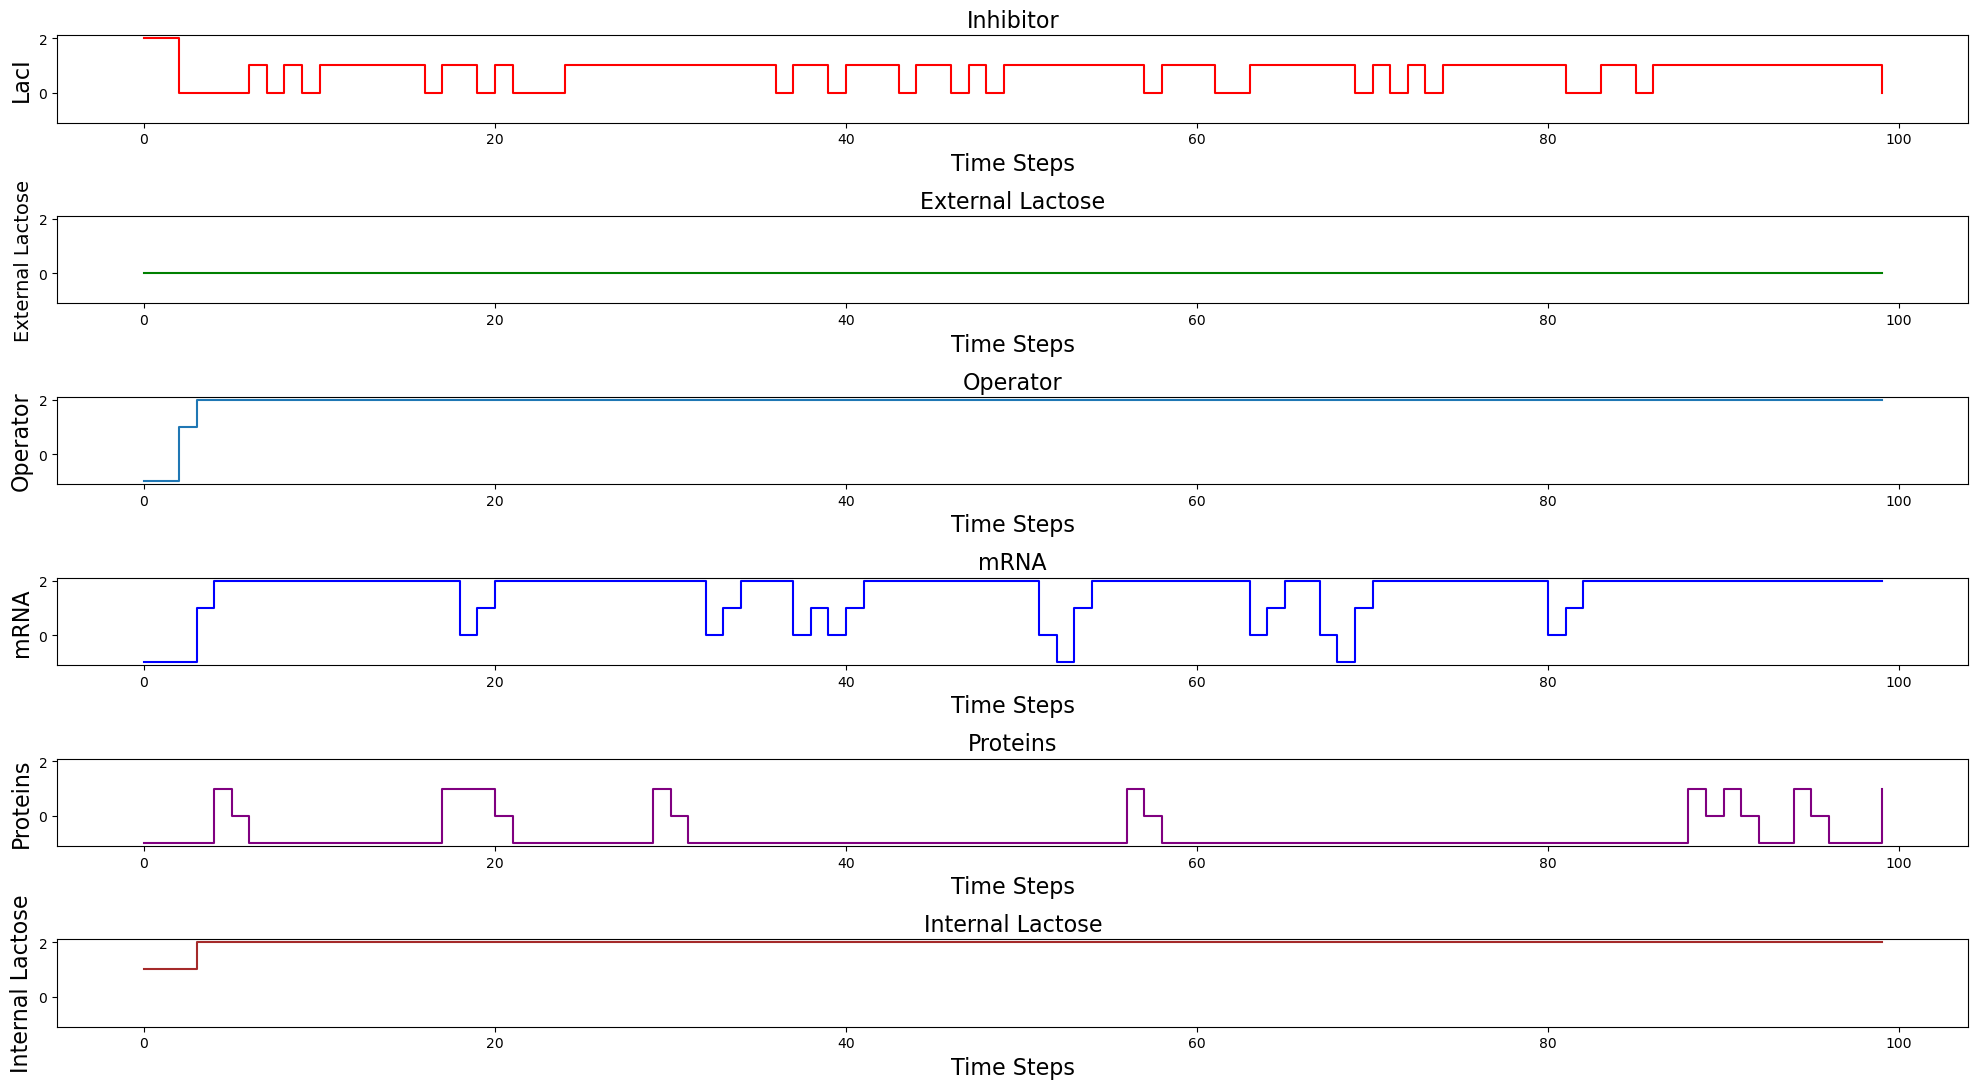

In [91]:
import numpy as np
import random

def update_state(current_state, probability):
    return 1 if random.random() < probability else 0
def simulate_system(params, steps=100):
    states = {'O': 0, 'I': 1, 'L': 1, 'Li': 0, 'M': 0, 'P': 0}
    history = np.zeros((steps, 6))
    for t in range(steps):
        if t>1:
            if states['Li']==1:
                states['Li']=2
            if states['Li']==0:
                states['Li']=(-1)

        # if we have external lactose
        if states['L'] == 1:
            # internal lactose is on
            states['Li']=1
            # external lactose is off 
            states['L']=0

        # if lactose is on
        if states['I']==0:
            states['I']=-1
        if states['I']==1:
            states['I']=2
        if states['Li'] == 2 and t>1 and states['I']>0:
            # if lactose has been on for the last 2 epochs

                # update the status of Inhibitor based on probability of binding of lactose to inhibitor
            temp_state = update_state(states['I'], 1-params['lactose_binding'])
            if temp_state==1:
                states['I']=states['I']
            else:
                states['I']=0
        # if lactose is off  
        elif states['Li']==(-1) and t>1 and states['I']<1:
            #if inhibitor is off

                # update inhibitor status based on ability of inhibitor to operon
            temp_state = update_state(states['I'], params['lacI_binding'])
            if temp_state==0:
                states['I']=states['I']
            else:
                states['I']=1
            

        if states['O']==0:
            states['O']=(-1)
        elif states['O']==1:
            states['O']=2

        if states['I'] == 0 and t>1 and states['O']!=2:

            states['O']=1
        elif states['I']==2 and t>1 and states['O']>0:
            states['O']=0




        if states['M']==0:
            states['M']=(-1)
        if states['M']==1:
            states['M']=2
        if states['O']==2 and t>2:
            # if operon has been on for the last 2 epochs and mRNA is off
            if states['M']<=0:
                # update mRNA 
                temp_state = update_state(states['M'], params['mRNA_production_withoutinitialoperator'])
                if temp_state==0:
                    states['M']=states['M']
                else:
                    states['M']=1
            # if operon has been on for the last 2 epochs and mRNA is on
            elif states['M']>=1:
                # update mRNA, with a probability of degradation
                temp_state1 = update_state(states['M'], params['mRNA_production_withinitialoperator'])
                #temp_state2=update_state(states['M'], 1-params['mRNA_degradation_withoperator'])
                if temp_state1==1:
                    states['M']=2
                else:
                    states['M']=0

            # enough epochs has not passed for operon state change to have an impact 
        elif states['O']==1:
            states['M']=states['M']
        elif states['O']==0:
            states['M']=states['M']
        # if operon is off    
        elif states['O']==(-1):
            # if operon has been of for more than 2 epochs, and mRNA is still on
            if states['M']>=1:
                # update status of mRNA, with high degradation
                states['M']=update_state(states['M'],params['mRNA_degradation_withoutoperator'])
        elif t<=2:
            states['M']=0


        if states['P']==0:
            states['P']=(-1)
        if states['P']==1:
            states['P']=2
        # if mRNA is on
        if states['M']==2 and t>2:
            # if mRNA has been on for the last 2 epochs and protein is off
            if states['P']<=0:
                # update protein
                temp_state = update_state(states['P'], params['protein_production_withoutinitialprotein'])
                if temp_state==0:
                    states['P']=states['P']
                else:
                    states['P']=1
             # if mRNA has been on for the last 2 epochs and protein is on
            elif states['P']>=1:
                # update protein, with a probability of degradation
                temp_state1 = update_state(states['P'], params['protein_production_withinitialprotein'])
                #temp_state2=update_state(states['P'], 1-params['protein_degradation_withmRNA'])
                if temp_state1==1:
                    states['P']=2
                else:
                    states['P']=0
            # enough epochs has not passed for mRNA state change to have an impact 
        elif states['M']==1:
            states['P']=states['P']
        elif states['M']==0:
            states['P']=states['P']
        # if mRNA is off      
        elif states['M']==(-1):
            # if mRNA has been of for more than 2 epochs, and protein is still on
            if states['P']>=1:
                # update status of protein, with high degradation
                states['P']=update_state(states['P'],1-params['protein_degradation_withoutmRNA'])
        elif t<=2:
            states['P']=0


        # if protein is on
        #print(t,states['Li'])
        if states['P']==2 and t>2:
            # if protein has been of for more than 2 epochs, and lactose is still on
            if states['Li']>=1:
                # switch off lactose
                temp_state=update_state(states['Li'], 1-params['lactose_internalization'])
                if temp_state==1:
                    states['Li']=states['Li']
                else:
                    states['Li']=0
            else:
                if states['Li']<=0:
                    states['Li']=states['Li']
        elif t<=2:
            states['Li']=1

        #print(t,states['Li'])   

        history[t] = [states['O'], states['I'], states['L'], states['Li'], states['M'], states['P']]
        # if lactose is off
        if states['Li'] == (-1):
            # if lactose has been off for the last 3 epochs

                # try to bring in external lactose
            states['L']=update_state(states['L'], params['entry of lactose'])
            history[t][2]=states['L']
        
        
    return history

history=simulate_system(initial_params,100)
from matplotlib import pyplot as plt
steps=len(history)


plt.figure(figsize=(20,11))


plt.subplot(6, 1, 1)
plt.step(range(steps), history[:,1], label='LacI', color='r', where='post')
plt.ylabel('LacI',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.title('Inhibitor',fontsize=16)
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 2)
plt.step(range(steps), history[:,2], label='Lactose', color='g', where='post')
plt.ylabel('External Lactose',fontsize=14)
plt.title('External Lactose',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 3)
plt.step(range(steps), history[:,0], label='Operator', where='post')
plt.ylabel('Operator',fontsize=16)
plt.title('Operator',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 4)
plt.step(range(steps), history[:,4], label='mRNA', color='b', where='post')
plt.ylabel('mRNA',fontsize=16)
plt.title('mRNA',fontsize=16)
plt.xlabel('Time Steps',fontsize=16)
plt.ylim(-1.1, 2.1)

plt.subplot(6, 1, 5)
plt.step(range(steps), history[:,5], label='Proteins', color='purple', where='post')
plt.ylabel('Proteins',fontsize=16)
plt.title('Proteins',fontsize=16)
plt.ylim(-1.1, 2.1)
plt.xlabel('Time Steps',fontsize=16)

plt.subplot(6, 1, 6)
plt.step(range(steps), history[:,3], label='Li', color='brown', where='post')
plt.ylabel('Internal Lactose',fontsize=16)
plt.title('Internal Lactose',fontsize=16)
plt.ylim(-1.1, 2.1)
plt.xlabel('Time Steps',fontsize=16)
#plt.savefig("Final_image_before_optimization.png")
plt.tight_layout()
plt.show()


# Visualize loss

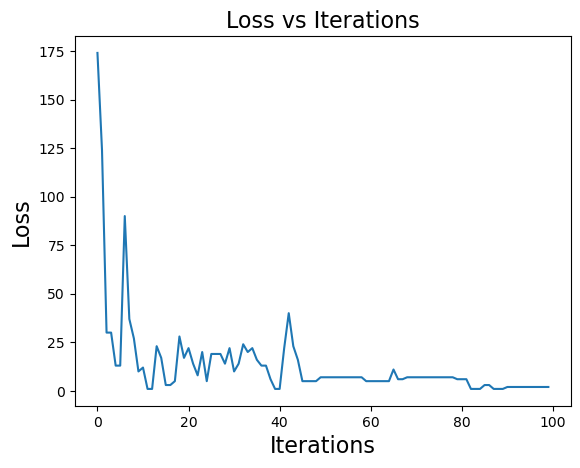

In [77]:
from matplotlib import pyplot as plt
len(bu_li)
plt.plot(bu_li)
plt.xlabel("Iterations",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.title("Loss vs Iterations",fontsize=16)
plt.savefig("Loss.png")